# Dogs vs Cats Redux

## Organize Data
- Download data with kaggle-cli into data folder, then unzip.
- data_dir should have subfolders train/ and test/ containing dog and cat images

In [3]:
# Imports
import os, sys, shutil, random
data_dir = '/home/ubuntu/fastai-data/redux'

In [ ]:
# Organize directories
%cd $data_dir
%mkdir valid
%mkdir results

%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results

### 1. Move/Copy data into appropriate directories

In [ ]:
# Create validation set
files = os.listdir(os.path.join(data_dir,'train'))
for f in random.sample(files, 2000):
    shutil.move(os.path.join(data_dir,'train',f), os.path.join(data_dir,'valid',f))

In [ ]:
# Create sample training set
files = os.listdir(os.path.join(data_dir,'train'))
for f in random.sample(files, 200):
    shutil.copy(os.path.join(data_dir,'train',f), os.path.join(data_dir,'sample','train',f))

In [ ]:
# Create sample validation set
files = os.listdir(os.path.join(data_dir,'valid'))
for f in random.sample(files, 50):
    shutil.copy(os.path.join(data_dir,'valid',f), os.path.join(data_dir,'sample','valid',f))

In [ ]:
# Create sample test set
files = os.listdir(os.path.join(data_dir,'test'))
for f in random.sample(files, 100):
    shutil.copy(os.path.join(data_dir,'test',f), os.path.join(data_dir,'sample','test',f))

### 2. Organize data into folders by category

In [ ]:
# Split into cats and dogs
directories = ['train','valid','sample/train','sample/valid']
directories = [os.path.join(data_dir, dir) for dir in directories]
for dir in directories:
    %cd $dir
    %mkdir cats
    %mkdir dogs
    %mv cat.*.jpg cats/
    %mv dog.*.jpg dogs/

In [ ]:
# Move unlabelled data into 'unknown' folder
directories = ['test','sample/test']
directories = [os.path.join(data_dir, dir) for dir in directories]
for dir in directories:
    %cd $dir
    %mkdir unknown
    %mv *.jpg unknown/

## Finetune VGG Model

In [2]:
# Import modules
from utils import *
from vgg16 import Vgg16
vgg = Vgg16()

from keras import backend
backend.set_image_dim_ordering('th')

# Instantiate plotting tool
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [12]:
# Configuration variables
train_path = os.path.join(data_dir,'train')
valid_path = os.path.join(data_dir,'valid')
test_path = os.path.join(data_dir,'test')
result_path = os.path.join(data_dir,'results')

batch_size = 64
val_batch_size = batch_size*2
no_epochs = 1

In [13]:
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=val_batch_size)
vgg.finetune(batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [14]:
for i in range(no_epochs):
    vgg.fit(batches, val_batches)
    weights_filename = 'weights_epoch{}.hf5'.format(i+1)
    vgg.model.save_weights(os.path.join(result_path,weights_filename))

Epoch 1/1
23000/23000 [==============================] - 754s - loss: 0.1208 - acc: 0.9685 - val_loss: 0.0663 - val_acc: 0.9815


## Generate predictions on test data

### 1. Make predictions on test data

In [15]:
#vgg.model.load_weights(os.path.join(result_path,'weights_epoch1.hf5'))
test_batches, predictions = vgg.test(test_path, batch_size=val_batch_size)

Found 12500 images belonging to 1 classes.


In [8]:
# imports
import numpy as np
from IPython.display import FileLink

In [36]:
# turn predictions into array of probabilities suitable for kaggle submission
isdog = predictions[:,1] # dog probability is second column
isdog = isdog.clip(min=.05, max=.95)
ids = np.array([int(f.split('.')[0].split('/')[-1]) for f in test_batches.filenames])
subm = np.stack([ids,isdog], axis=1) # id is first column, dog probability is second column
subm[:5]

array([[  1.0000e+00,   9.5000e-01],
       [  1.0000e+01,   5.0000e-02],
       [  1.0000e+02,   5.0000e-02],
       [  1.0000e+03,   9.5000e-01],
       [  1.0000e+04,   9.5000e-01]])

### 2. Check some random images

In [29]:
from keras.preprocessing import image

def show_image_label(ids, labels, path):
    plots([image.load_img(os.path.join(path, str(int(_id))+'.jpg')) for _id in ids], titles=labels)

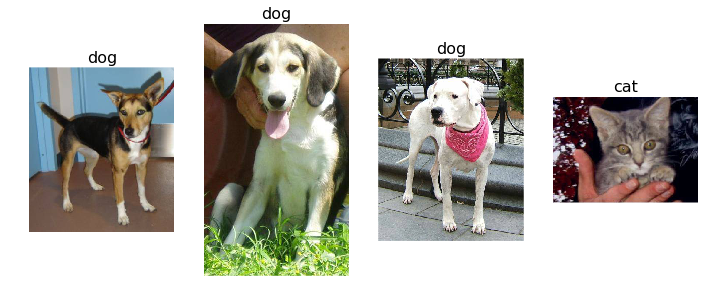

In [35]:
idx = np.random.randint(np.shape(subm)[0], size=4)
ids = subm[idx,0]
labels = ['dog' if prb > .5 else 'cat' for prb in subm[idx,1]]
image_path = os.path.join(test_path,'unknown')

show_image_label(ids, labels, image_path)

### 3. Save CSV and download to submit to kaggle

In [38]:
subm_filename = 'redux_subm.csv'
np.savetxt(subm_filename, subm, fmt='%d,%.5f', header='id,label', comments='')

In [39]:
FileLink(subm_filename)

/home/ubuntu/fastai-notes/nbs/redux_subm.csv